In [1]:
import re
import nltk
import collections
import tensorflow as tf
import math
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
import random

In [2]:
#get training docs
documents = reuters.fileids()
train_docs = list(filter(lambda doc: doc.startswith("train"),documents));

In [3]:
#stop list
StopWords = stopwords.words("english")

#stemmer
stemmer = PorterStemmer()

#min length of word in final tokens
min_length = 3

vocabulary_size = 50000

In [4]:
#tokenize training set corpus
words = []
for fileid in train_docs:
    words.append(list(reuters.words(fileids = [fileid])))
print(words[0])

[u'BAHIA', u'COCOA', u'REVIEW', u'Showers', u'continued', u'throughout', u'the', u'week', u'in', u'the', u'Bahia', u'cocoa', u'zone', u',', u'alleviating', u'the', u'drought', u'since', u'early', u'January', u'and', u'improving', u'prospects', u'for', u'the', u'coming', u'temporao', u',', u'although', u'normal', u'humidity', u'levels', u'have', u'not', u'been', u'restored', u',', u'Comissaria', u'Smith', u'said', u'in', u'its', u'weekly', u'review', u'.', u'The', u'dry', u'period', u'means', u'the', u'temporao', u'will', u'be', u'late', u'this', u'year', u'.', u'Arrivals', u'for', u'the', u'week', u'ended', u'February', u'22', u'were', u'155', u',', u'221', u'bags', u'of', u'60', u'kilos', u'making', u'a', u'cumulative', u'total', u'for', u'the', u'season', u'of', u'5', u'.', u'93', u'mln', u'against', u'5', u'.', u'81', u'at', u'the', u'same', u'stage', u'last', u'year', u'.', u'Again', u'it', u'seems', u'that', u'cocoa', u'delivered', u'earlier', u'on', u'consignment', u'was', u'incl

In [5]:
#lowercasing the text
#remove the words if present in stop list
#stemming
#removing non alphanumeric and numeric text 
text_processed = []
p = re.compile('[a-zA-Z]+');
for doc in words:
    doc = map(lambda word: word.lower(), doc);
    doc = [word for word in doc if word not in StopWords]# change here
    doc = [stemmer.stem(word) for word in doc]
    filtered_tokens =list(filter(lambda token:p.match(token) ,doc));# change here
    text_processed.append(filtered_tokens)

In [6]:
#list of all the tokens
combined_text = []
for doc in text_processed:
    combined_text = combined_text + doc


In [7]:
#data in terms of index
#dictionary maps words to indexes
#count is list of tupples which comprise of word and its count
def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary
data, count, dictionary, reverse_dictionary = build_dataset(combined_text)

In [8]:
count[0:10]

[['UNK', 0],
 (u'said', 18845),
 (u'mln', 13115),
 (u'dlr', 9879),
 (u'vs', 9295),
 (u'pct', 7425),
 (u'year', 6592),
 (u'lt', 6302),
 (u'ct', 5963),
 (u'u', 4630)]

In [9]:
#convert text_processed to integer indexes
def convert(text,dictionary):
    index_processed=[]
    for doc in text:
        doc_temp = []
        for word in doc:
           # print(word)
            if word in dictionary:
                doc_temp.append(dictionary[word])
                #print(word)
            else:
                doc_temp.append(0)
        index_processed.append(doc_temp)
    return index_processed
index_processed = convert(text_processed,dictionary)


In [10]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [11]:


batch_size = 40
embedding_size = 256 # Dimension of the embedding vector.
skip_window = 5 # How many words to consider left and right.
num_skips = 10 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
#valid_size = 16 # Random set of words to evaluate similarity on.
#valid_window = 100 # Only pick dev samples in the head of the distribution.
#valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    with tf.device('/cpu:0'):

      # Input data.
      train_dataset = tf.placeholder(tf.float32, shape=[batch_size])
      train_labels = tf.placeholder(tf.float32, shape=[batch_size, 1])
      #valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

      # Variables.
      embeddings = tf.Variable(dtype=tf.float32,initial_value=
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      softmax_weights = tf.Variable(dtype=tf.float32,initial_value=
        tf.truncated_normal([vocabulary_size, embedding_size],mean=0,
                             stddev=1.0 / math.sqrt(embedding_size)))
      softmax_biases = tf.Variable(dtype=tf.float32,initial_value=tf.zeros([vocabulary_size]))

      # Model.
      # Look up embeddings for inputs.
      embed = tf.nn.embedding_lookup(embeddings, tf.cast(train_dataset,dtype=tf.int32))
      # Compute the softmax loss, using a sample of the negative labels each time.
    
      loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
      print(loss)

      # Optimizer.
      # Note: The optimizer will optimize the softmax_weights AND the embeddings.
      # This is because the embeddings are defined as a variable quantity and the
      # optimizer's `minimize` method will by default modify all variable quantities 
      # that contribute to the tensor it is passed.
      # See docs on `tf.train.Optimizer.minimize()` for more details.
    with tf.device('/cpu:0'):
      optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Compute the similarity between minibatch examples and all embeddings.
      # We use the cosine distance:
      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
      normalized_embeddings = embeddings / norm
      #valid_embeddings = tf.nn.embedding_lookup(
        #normalized_embeddings, valid_dataset)
      #similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))



Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)


In [12]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
#     if step % 10000 == 0:
#       sim = similarity.eval()
#       for i in range(valid_size):
#         valid_word = reverse_dictionary[valid_examples[i]]
#         top_k = 8 # number of nearest neighbors
#         nearest = (-sim[i, :]).argsort()[1:top_k+1]
#         log = 'Nearest to %s:' % valid_word
#         for k in range(top_k):
#           close_word = reverse_dictionary[nearest[k]]
#           log = '%s %s,' % (log, close_word)
#         print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.988937
Average loss at step 2000: 6.172769
Average loss at step 4000: 5.275990
Average loss at step 6000: 4.867577
Average loss at step 8000: 4.653482
Average loss at step 10000: 4.569246
Average loss at step 12000: 4.495545
Average loss at step 14000: 4.363618
Average loss at step 16000: 4.348904
Average loss at step 18000: 4.313492
Average loss at step 20000: 4.359516
Average loss at step 22000: 4.192402
Average loss at step 24000: 4.187101
Average loss at step 26000: 4.127006
Average loss at step 28000: 4.116182
Average loss at step 30000: 4.103845
Average loss at step 32000: 4.086871
Average loss at step 34000: 4.115992
Average loss at step 36000: 4.140435
Average loss at step 38000: 4.071464
Average loss at step 40000: 4.052169
Average loss at step 42000: 4.021844
Average loss at step 44000: 3.864995
Average loss at step 46000: 3.793477
Average loss at step 48000: 3.789845
Average loss at step 50000: 3.774583
Average loss at step 52000: 3.8079

In [13]:
final_embeddings.shape


(50000, 256)

In [14]:
from sklearn.manifold import TSNE
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

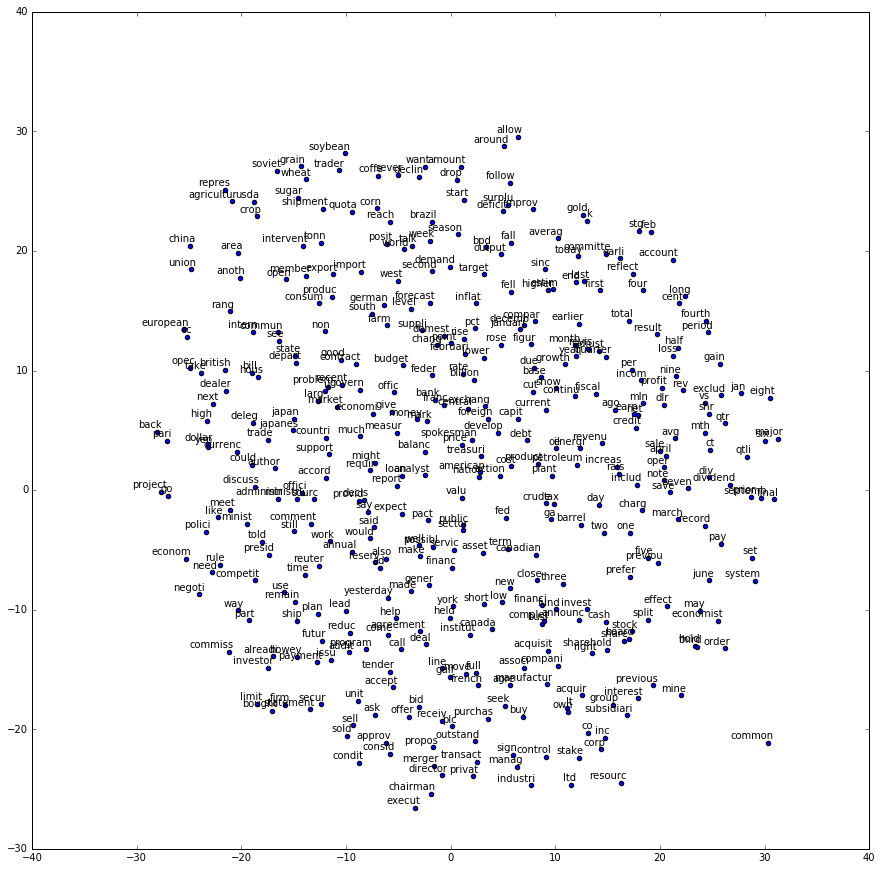

In [15]:
from matplotlib import pylab
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [16]:
save = {'embeddings': final_embeddings,'dictionary': dictionary,'reverse_dictionary': reverse_dictionary}

In [17]:
save['reverse_dictionary']

{0: 'UNK',
 1: u'said',
 2: u'mln',
 3: u'dlr',
 4: u'vs',
 5: u'pct',
 6: u'year',
 7: u'lt',
 8: u'ct',
 9: u'u',
 10: u'net',
 11: u'loss',
 12: u'share',
 13: u'billion',
 14: u'compani',
 15: u'bank',
 16: u'would',
 17: u'shr',
 18: u'price',
 19: u'trade',
 20: u'inc',
 21: u'market',
 22: u'profit',
 23: u'oper',
 24: u'oil',
 25: u'last',
 26: u'sale',
 27: u'corp',
 28: u'rate',
 29: u'stock',
 30: u'one',
 31: u'tonn',
 32: u'export',
 33: u'new',
 34: u'two',
 35: u'product',
 36: u'also',
 37: u'expect',
 38: u'offer',
 39: u'report',
 40: u'industri',
 41: u'end',
 42: u'month',
 43: u'march',
 44: u'qtr',
 45: u'increas',
 46: u'offici',
 47: u'rev',
 48: u'unit',
 49: u'januari',
 50: u'februari',
 51: u'group',
 52: u'per',
 53: u'april',
 54: u'note',
 55: u'week',
 56: u'includ',
 57: u'quarter',
 58: u'co',
 59: u'may',
 60: u'govern',
 61: u'first',
 62: u'japan',
 63: u'rise',
 64: u'dollar',
 65: u'agreement',
 66: u'exchang',
 67: u'import',
 68: u'total',
 69: 

In [18]:
import pickle
with open("dict.dat", "wb") as f:
    data = pickle.dump(save, f)


In [19]:
len(dictionary)

18067

In [20]:
rand_index = np.random.randint(18000, size=500)

In [21]:
# graph = tf.Graph()
# with graph.as_default():
#     with tf.device('/cpu:0'):
#         vectors = tf.constant(final_embeddings)
#         rindex = tf.constant(rand_index)
#         embed1 = tf.nn.embedding_lookup(vectors,rindex)
#         similarity = tf.matmul(vectors,tf.transpose(embed1))
# with tf.Session(graph=graph) as session:
#     tf.global_variables_initializer().run()
#     sim = session.run(similarity)
#     print(sim)

In [22]:
sim = np.dot(final_embeddings,final_embeddings[rand_index].transpose())

In [23]:
final_embeddings.shape

(50000, 256)

In [24]:
rand_words=[]
for i in rand_index:
    rand_words.append(reverse_dictionary[i])
rand_words = np.array(rand_words)
print(rand_words.shape)


(500,)


In [25]:
print sim.argsort(axis=0)


[[ 8002  8192 22846 ..., 19351 16542 42069]
 [40072  8150 42985 ...,  1716 46370 10002]
 [43306 27427 30634 ..., 30810 46052 15029]
 ..., 
 [19203 19324 20252 ...,  2498 27513 21747]
 [30772 34021 23191 ..., 16646 31207 47938]
 [ 2175 11676  8313 ...,   688  1529 13124]]


In [26]:
sort_index = sort_index[-11:-1,:]

NameError: name 'sort_index' is not defined

In [ ]:
sort_index = sort_index.transpose()

In [ ]:
print(sort_index)

In [ ]:
sort_index = sim.argsort(axis=0)
sort_index = sort_index[-11:-1,:]
sort_index = sort_index.transpose()
words_sorted = []
for x in sort_index:
    temp = []
    for index in x:
        temp.append(reverse_dictionary[index])
    words_sorted.append(temp)

words_sorted = np.array(words_sorted)
#print(words_sorted)
print(words_sorted.shape)




In [ ]:
print(rand_words)

In [ ]:
for i in range(500):
    print(rand_words[i])
    print(words_sorted[i])